In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST)

In [2]:
path = Path('./classification_dataset/')

In [3]:
path.ls()

(#1) [Path('classification_dataset/training')]

In [4]:
path.ls()

(#1) [Path('classification_dataset/training')]

In [5]:
# import albumentations

# class AlbumentationsTransform(DisplayedTransform):
#     split_idx,order=0,2
#     def __init__(self, train_aug): store_attr()
    
#     def encodes(self, img: PILImage):
#         aug_img = self.train_aug(image=np.array(img))['image']
#         return PILImage.create(aug_img)
    
# def get_train_aug(): return albumentations.Compose([
#     albumentations.Affine()
#     # albumentations.Flip(p=0.5),
#     # albumentations.CoarseDropout(p=0.5),
#     # albumentations.Cutout(p=0.5),
#     # albumentations.Rotate(limit=45)
# ])

# item_tfms = [Resize(384), AlbumentationsTransform(get_train_aug())]


In [6]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, item_tfms=[Resize(384)],
        batch_tfms=aug_transforms(mult=1.5, size=384, min_scale=0.75))

/home/dnth/anaconda3/envs/paddy/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


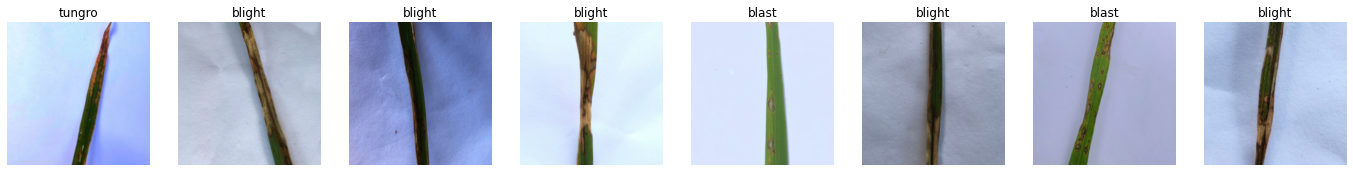

In [7]:
loaders = block.dataloaders(path/"training")
loaders.train.show_batch(max_n=8, nrows=1)

In [8]:
learn = cnn_learner(loaders, resnet34, metrics=accuracy)

In [9]:
# learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.004635,1.302890,0.479167,00:08


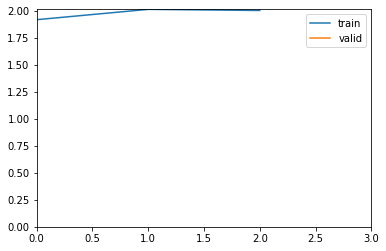

epoch,train_loss,valid_loss,accuracy,time
0,1.214137,1.021898,0.604167,00:08
1,1.171345,0.718495,0.708333,00:08
2,1.066542,0.518369,0.812500,00:08
3,0.948950,0.352571,0.812500,00:08
4,0.814937,0.218845,0.937500,00:08
5,0.708263,0.151282,0.937500,00:09
6,0.629283,0.128200,0.958333,00:08
7,0.551065,0.117213,0.958333,00:08
8,0.487036,0.104024,0.979167,00:08
9,0.432594,0.098262,0.979167,00:08


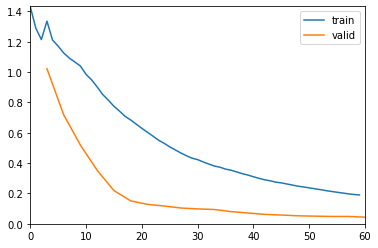

In [10]:
learn.fine_tune(20, base_lr=1e-3, cbs=[ShowGraphCallback()])

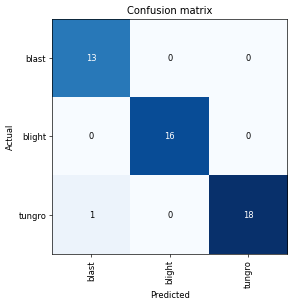

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [12]:
interp.most_confused(min_val=5)

[]

In [13]:
img_files = get_image_files(path)
im = PILImage.create(img_files[0])
im.shape
im.to_thumb(160)

x, = first(loaders.test_dl([im]))

In [14]:
with torch.no_grad(): output = learn.model.eval()(x)
F.softmax(output, dim=-1)

TensorBase([[0.0086, 0.9902, 0.0012]], device='cuda:0')

In [15]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [16]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [24]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

/home/dnth/anaconda3/envs/paddy/lib/python3.8/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [25]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

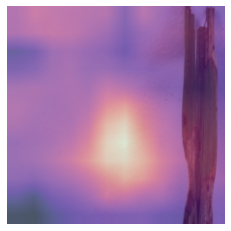

In [26]:
_,ax = plt.subplots()
x_dec = TensorImage(loaders.train.decode((x,))[0][0])
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [20]:
learn.export("models/learner.pkl")
# learn = load_learner('models/fastai-99acc.pkl')

In [21]:
# test_dl = learn.dls.test_dl(get_image_files(path/"testing"), with_labels=True)

In [22]:
# fastai_loss, fastai_accuracy = learn.validate(dl=test_dl)

In [23]:
# print_loss_acc(fastai_loss, fastai_accuracy)